In [63]:
!pip install yfinance


#Step 1: Get Stock Data

In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [65]:
ticker = yf.Ticker("RELIANCE.NS")
data = ticker.history(period = "15y", interval = "1d")
data.head()



,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-06-30,76.59,77.20,75.25,75.95,46068444,0.0,0.0
2005-07-01,76.00,76.24,75.36,75.66,22496339,0.0,0.0
2005-07-04,75.88,76.77,75.53,76.17,24424609,0.0,0.0
2005-07-05,76.12,76.59,75.23,75.42,30094749,0.0,0.0
2005-07-06,75.34,76.48,75.34,76.26,21495287,0.0,0.0


In [66]:
# Sort the dataframe according to the date
data.sort_values('Date', inplace=True, ascending=True)

# Print the dataframe top
data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-06-30,76.59,77.20,75.25,75.95,46068444,0.0,0.0
2005-07-01,76.00,76.24,75.36,75.66,22496339,0.0,0.0
2005-07-04,75.88,76.77,75.53,76.17,24424609,0.0,0.0
2005-07-05,76.12,76.59,75.23,75.42,30094749,0.0,0.0
2005-07-06,75.34,76.48,75.34,76.26,21495287,0.0,0.0


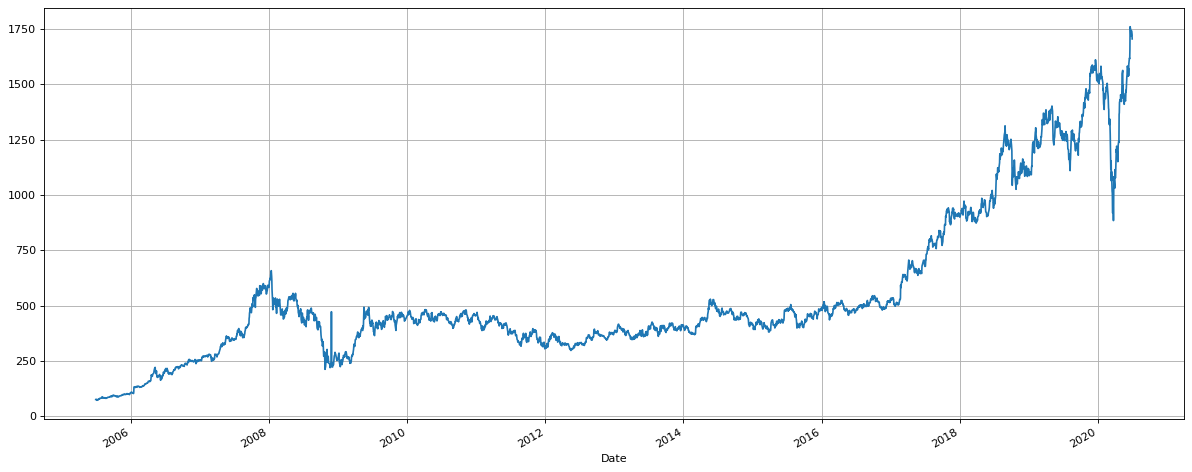

In [67]:
# Visualization of data. Plotting the price close.
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
data['Close'].plot()
plt.tight_layout()
plt.grid()
plt.show()

#Step 2: Create the Dataset

In [68]:
# Get Close data
df = data[['Close']].copy()
# Split data into train and test
train, test = df.iloc[0:-200], df.iloc[-200:len(df)]
print(len(train), len(test))

#print(train.iloc[0:10].values)

3486 200


In [69]:

train_max = train.max()
train_min = train.min()

# Normalize the dataframes
train = (train - train_min)/(train_max - train_min)
test = (test - train_min)/(train_max - train_min)

In [70]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
     #print(np.array(Xs), np.array(ys))
    return np.array(Xs), np.array(ys)


time_steps = 1

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

#Step 3:Create the Model and Train

In [71]:

import tensorflow as tf
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.LSTM(250, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    shuffle=False
)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 250)               252000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 251       
Total params: 252,251
Trainable params: 252,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
109/109 [==============================] - 0s 3ms/step - loss: 0.0603
Epoch 2/50
109/109 [==============================] - 0s 3ms/step - loss: 0.1112
Epoch 3/50
109/109 [==============================] - 0s 3ms/step - loss: 0.0714
Epoch 4/50
109/109 [==============================] - 0s 3ms/step - loss: 0.0422
Epoch 5/50
109/109 [==============================] - 

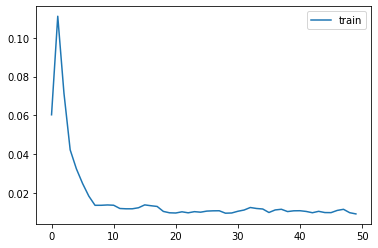

In [72]:
plt.plot(history.history['loss'], label='train')
plt.legend();
plt.show()

#Step 4: Predict!

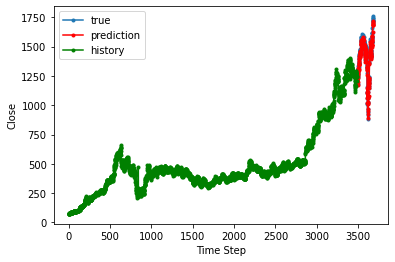

In [73]:
y_pred = model.predict(X_test)

# Rescale the data back to the original scale
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]

# Plotting the results
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='.', label="prediction")
plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', marker='.', label="history")
plt.ylabel('Close')
plt.xlabel('Time Step')
plt.legend()

plt.show()